#### Master of Data Science (Digital Humanities), Durham University
#### Final Project Notebooks

### DATA40345 Data Science Research Project

#### NLP Esquire: A Data-Driven Analysis and Categorisation of the Judgments of the United Kingdom Supreme Court

## Notebook 4: Multi-Class Classification 

In [1]:
#libraries for data processing, cleaning, manipulation, sampling
import pandas as pd
import numpy as np

from nltk import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.utils import resample

#library for training/testing
from sklearn.model_selection import train_test_split
import random

#libraries/packages for implementing traditional classifiers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.model_selection import cross_val_score

#libraries/packages for implementing deep learning architectures
import torch
from torchtext.legacy import data #For handling text data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim as optim

#libraries for evaluation metrics of classifiers
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score,precision_score,recall_score,classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
import time
import tqdm

#visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#loading the dataset with the case id and labels using pandas
labels = pd.read_csv("UKSC_Labelled_FINAL for ML.csv", names=["title", "label"])
labels.head(10)

#https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

,title,label
0,uksc-2009-0015-judgment-01,human rights
1,uksc-2009-0019-judgment,family
2,uksc-2009-0020-judgment,human rights
3,uksc-2009-0022-judgment,immigration
4,uksc-2009-0031-judgment,family
5,uksc-2009-0032-judgment,tort
6,uksc-2009-0034-judgment,family
7,uksc-2009-0036-judgment,international
8,uksc-2009-0037-judgment,land
9,uksc-2009-0038-judgment,land


In [3]:
counts = labels["label"].value_counts()
counts

criminal                    99
immigration                 98
admin                       95
human rights                76
international               65
tax                         62
labour                      51
contract                    49
land                        47
tort                        46
company                     45
family                      37
insurance                   25
procedure                   20
constitutional              19
intellectual property       19
shipping                     7
mental capacity              6
arbitration                  6
equity                       5
competition                  5
banking                      4
civil                        4
trust                        3
damages                      3
security                     3
mental health                2
public                       2
contempt                     2
jurisdiction                 2
private                      1
public health                1
medical 

In [4]:
#loading the dataset with the case id and the judgment text
text = pd.read_csv("UKSC Judgments.csv")
text.head(4)

,title,text
0,uksc-2009-0015-judgment-01,Hilary Term \n[2010] UKSC 1 \n\nJUDGMENT \n\nA...
1,uksc-2009-0019-judgment,Michaelmas Term \n[2009] UKSC 5 \nOn appeal fr...
2,uksc-2009-0020-judgment,Michaelmas Term \n[2009] UKSC 12 \nOn appeal f...
3,uksc-2009-0022-judgment,Easter Term \n[2011] UKSC 23 \nOn appeal from:...


In [5]:
labels.info()
print()
text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   918 non-null    object
 1   label   918 non-null    object
dtypes: object(2)
memory usage: 14.5+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   918 non-null    object
 1   text    918 non-null    object
dtypes: object(2)
memory usage: 14.5+ KB


Merge the two dataframes on "title" column

In [6]:
#merge on title using merge() method
merge_df = text.merge(labels, on="title")
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 918 entries, 0 to 917
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   918 non-null    object
 1   text    918 non-null    object
 2   label   918 non-null    object
dtypes: object(3)
memory usage: 28.7+ KB


In [7]:
merge_df.head(5)

,title,text,label
0,uksc-2009-0015-judgment-01,Hilary Term \n[2010] UKSC 1 \n\nJUDGMENT \n\nA...,human rights
1,uksc-2009-0019-judgment,Michaelmas Term \n[2009] UKSC 5 \nOn appeal fr...,family
2,uksc-2009-0020-judgment,Michaelmas Term \n[2009] UKSC 12 \nOn appeal f...,human rights
3,uksc-2009-0022-judgment,Easter Term \n[2011] UKSC 23 \nOn appeal from:...,immigration
4,uksc-2009-0031-judgment,Michaelmas Term \n[2010] UKSC 42 \nOn appeal f...,family


In [8]:
#save as csv for future use
merge_df.to_csv("UKSC_FINAL Labelled Judgments_918.csv", index=False)

There are more than 40 labels. Some of the linked areas of law are collated together. To simplify the classification process, the following steps are taken: 

1. The labels "corporate", "intellectual property", "arbitration" are collated under/replaced by label "corporate".


2. The label "fraud" is collated under/replaced by label "criminal" as fraud is a criminal offence.


3. The labels "procedure", "shipping", "mental capacity", "competition", "equity", "banking", "civil", "trust", "damages", "security", "public", "jurisdiction","contempt", "mental health", "legal aid", "consumer protection","private", "statutory interpretation", "medical ", "public health","fishing", "communications", "telecom", and "construction" are collated under/replaced by label "other". 

In [8]:
#identify labels to replace
label_replace_corporate = ['company', 'intellectual property', 'arbitration']
label_replace_other = ["procedure", "shipping", "mental capacity", "competition", "equity",
                      "banking", "civil", "trust", "damages", "security", "public", "jurisdiction",
                      "contempt", "mental health", "legal aid", "consumer protection",
                      "private", "statutory interpretation", "medical ", "public health",
                      "fishing", "communications", "telecom", "construction"]
label_replace_fraud = ["fraud"]

#replace the relevant labels with "corporate"
merge_df["label"] = merge_df["label"].apply(lambda x: "corporate" if x in label_replace_corporate else x)

#replace the relevant labels with "other"
merge_df["label"] = merge_df["label"].apply(lambda x: "other" if x in label_replace_other else x)

#replace the relevant labels with "criminal"
merge_df["label"] = merge_df["label"].apply(lambda x: "criminal" if x in label_replace_fraud else x)

#check if it has been properly done
counts = merge_df["label"].value_counts()
counts

criminal          100
immigration        98
admin              95
other              78
human rights       76
corporate          70
international      65
tax                62
labour             51
contract           49
land               47
tort               46
family             37
insurance          25
constitutional     19
Name: label, dtype: int64

In [10]:
#save as csv for future use
merge_df.to_csv("UKSC_15_FINAL Labelled Judgments_918.csv", index=False)

Exploratory Data Analysis

In [9]:
df = merge_df

In [10]:
df.shape
print("The dataset has", df.shape[0], "rows and", df.shape[1], "columns")

The dataset has 918 rows and 3 columns


In [11]:
#assess the no. of labels available 
counts = df["label"].value_counts()
print(counts)
print()

criminal          100
immigration        98
admin              95
other              78
human rights       76
corporate          70
international      65
tax                62
labour             51
contract           49
land               47
tort               46
family             37
insurance          25
constitutional     19
Name: label, dtype: int64



In [14]:
#verify how many labels are available
unique = df["label"].nunique()

print("There are", unique, "unique labels in the dataset")

There are 15 unique labels in the dataset


### Selecting a Subset of Labelled Judgments

Rationale: a subset of 8 areas of law, namely, criminal, immigration, human rights, corporate, international, tax, labour are selected for the following reasons: 

1. These areas of law involve frequent interactions between individuals, organisations, and the State.
2. They address matters at both individual and collective levels.
3. The other areas of law tend to apply in more individualised circumstances, and possibly in specific situations. 
4. They also, comparatively, occur or are appealed to the UKSC, less frequently. 

In [12]:
specific_labels = ["immigration", "human rights", "criminal", "admin",
                  "corporate", "international", "tax", "labour"]
new_df = df[df["label"].isin(specific_labels)]

In [13]:
new_df.head(4)

,title,text,label
0,uksc-2009-0015-judgment-01,Hilary Term \n[2010] UKSC 1 \n\nJUDGMENT \n\nA...,human rights
2,uksc-2009-0020-judgment,Michaelmas Term \n[2009] UKSC 12 \nOn appeal f...,human rights
3,uksc-2009-0022-judgment,Easter Term \n[2011] UKSC 23 \nOn appeal from:...,immigration
7,uksc-2009-0036-judgment,Michaelmas Term \n[2012] UKSC 54 \nOn appeal f...,international


In [14]:
multi_labels = new_df
multi_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 617 entries, 0 to 916
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   617 non-null    object
 1   text    617 non-null    object
 2   label   617 non-null    object
dtypes: object(3)
memory usage: 19.3+ KB


In [15]:
multi_labels

,title,text,label
0,uksc-2009-0015-judgment-01,Hilary Term \n[2010] UKSC 1 \n\nJUDGMENT \n\nA...,human rights
2,uksc-2009-0020-judgment,Michaelmas Term \n[2009] UKSC 12 \nOn appeal f...,human rights
3,uksc-2009-0022-judgment,Easter Term \n[2011] UKSC 23 \nOn appeal from:...,immigration
7,uksc-2009-0036-judgment,Michaelmas Term \n[2012] UKSC 54 \nOn appeal f...,international
10,uksc-2009-0042-judgment,Michaelmas Term \n[2012] UKSC 43 \nOn appeal f...,labour
...,...,...,...
910,uksc-2021-0195-judgment,Trinity Term \n[2023] UKSC 23 \nOn appeal from...,human rights
912,uksc-2021-0216-judgment,Hilary Term \n[2023] UKSC 12 \nOn appeal from:...,tax
913,uksc-2022-0052-judgment,Hilary Term \n[2023] UKSC 13 \nOn appeal from:...,admin
914,uksc-2022-0056-judgment,Easter Term \n[2023] UKSC 14 \nOn appeal from:...,human rights


Evaluate Class Balance in Dataset

In [16]:
#assess the class balance of the three labels selected
counts = multi_labels["label"].value_counts()

print("No.of Judgments labelled 'criminal'     : ", counts[0])
print("No.of Judgments labelled 'immigration'  : ", counts[1])
print("No.of Judgments labelled 'admin'        : ", counts[2])
print("No.of Judgments labelled 'human rights' : ", counts[3])
print("No.of Judgments labelled 'corporate'    : ", counts[4])
print("No.of Judgments labelled 'international': ", counts[5])
print("No.of Judgments labelled 'tax'          : ", counts[6])
print("No.of Judgments labelled 'labour'       : ", counts[7])

No.of Judgments labelled 'criminal'     :  100
No.of Judgments labelled 'immigration'  :  98
No.of Judgments labelled 'admin'        :  95
No.of Judgments labelled 'human rights' :  76
No.of Judgments labelled 'corporate'    :  70
No.of Judgments labelled 'international':  65
No.of Judgments labelled 'tax'          :  62
No.of Judgments labelled 'labour'       :  51


In [17]:
#use groupby to collate judgments based on label
class_bal = multi_labels.groupby(["label"]).size()

#name the column with the counts
class_bal = class_bal.rename("Count").reset_index()
class_bal

,label,Count
0,admin,95
1,corporate,70
2,criminal,100
3,human rights,76
4,immigration,98
5,international,65
6,labour,51
7,tax,62


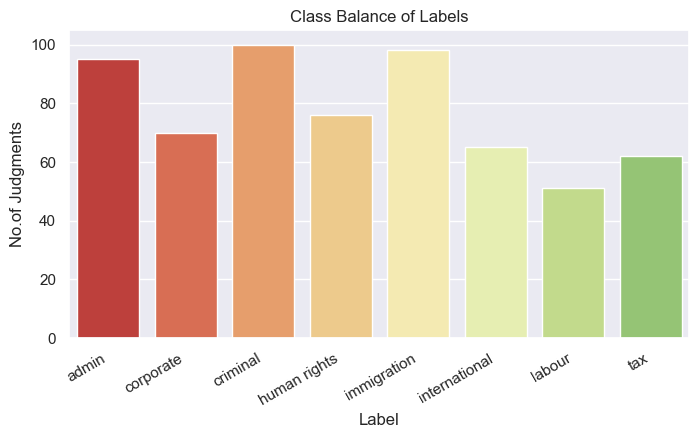

In [22]:
#visualise class balance
sns.set(style="darkgrid")
plt.figure(figsize=(8,4))

color= sns.color_palette("RdYlGn", 10)

sns.barplot(x="label", y="Count", data=class_bal, palette=color ).set(title="Class Balance of Labels")
plt.xticks(rotation=30, ha='right')

plt.xlabel("Label")
plt.ylabel("No.of Judgments")
plt.savefig("ClassBal_Original_8")

Prepare dataset for training

In [18]:
#drop title column
multi_label_final = multi_labels.drop(columns=["title"])
multi_label_final

,text,label
0,Hilary Term \n[2010] UKSC 1 \n\nJUDGMENT \n\nA...,human rights
2,Michaelmas Term \n[2009] UKSC 12 \nOn appeal f...,human rights
3,Easter Term \n[2011] UKSC 23 \nOn appeal from:...,immigration
7,Michaelmas Term \n[2012] UKSC 54 \nOn appeal f...,international
10,Michaelmas Term \n[2012] UKSC 43 \nOn appeal f...,labour
...,...,...
910,Trinity Term \n[2023] UKSC 23 \nOn appeal from...,human rights
912,Hilary Term \n[2023] UKSC 12 \nOn appeal from:...,tax
913,Hilary Term \n[2023] UKSC 13 \nOn appeal from:...,admin
914,Easter Term \n[2023] UKSC 14 \nOn appeal from:...,human rights


Splitting the data to training and test sets

In [19]:
#training set: 80% of the samples
#test set: 20% of the samples
#this is so that the test set can be kept separate only to evaluate performance
from sklearn.model_selection import train_test_split

x = multi_label_final.drop("label", axis=1)
y = multi_label_final["label"]

training_data, test_data = train_test_split(multi_label_final, test_size=0.2, stratify=y, random_state=42)

#check size of each set
print("Size of Training samples: ", len(training_data))
print("Size of Test samples    : ", len(test_data))
print()

#check class distribution across both sets
train_count = training_data["label"].value_counts()
test_count = test_data["label"].value_counts()

Size of Training samples:  493
Size of Test samples    :  124



In [25]:
print("The Number of classes in in Training Samples are:")
print(train_count)

The Number of classes in in Training Samples are:
criminal         80
immigration      78
admin            76
human rights     61
corporate        56
international    52
tax              49
labour           41
Name: label, dtype: int64


In [26]:
print("The Number of classes in in Test Samples are:")
print(test_count)

The Number of classes in in Test Samples are:
immigration      20
criminal         20
admin            19
human rights     15
corporate        14
international    13
tax              13
labour           10
Name: label, dtype: int64


In [27]:
#convert object type to string for preprocessing
training_data = training_data.astype({"text":"string"})
test_data = test_data.astype({"text":"string"})

#check data types
print("Data types in Training set :\n", training_data.dtypes)
print()
print("Data types in Test set :\n", test_data.dtypes)

Data types in Training set :
 text     string
label    object
dtype: object

Data types in Test set :
 text     string
label    object
dtype: object


In [28]:
#check for missing data
print("Missing data in Training Set: \n", training_data.isna().sum())
print()
print("Missing data in Test Set: \n", test_data.isna().sum())

Missing data in Training Set: 
 text     0
label    0
dtype: int64

Missing data in Test Set: 
 text     0
label    0
dtype: int64


Now that the training and test samples are prepared, the two samples need to be tokenised. 

In [21]:
#in order to tokenise:

#create a list of articles + labels for both training and test samples
training_text = training_data["text"].tolist()
training_label = training_data["label"].tolist()

test_text = test_data["text"].tolist()
test_label = test_data["label"].tolist()

#confirm the same no.of articles and labels in both samples
print("No.of judgments in Training set: ", len(training_text))
print("No.of labels in Training set: ", len(training_label))
print("No.of judgments in Test set: ", len(test_text))
print("No.of labels in Training set: ", len(test_label))

No.of judgments in Training set:  493
No.of labels in Training set:  493
No.of judgments in Test set:  124
No.of labels in Training set:  124


In [22]:
#tokenize each article to its lowercase words

training_tokens = []
training_label_final = []
test_tokens = []
test_label_final = []

for i in range(len(training_text)):
    try: 
        tokens = word_tokenize(training_text[i].lower()) #tokenise+lowercase
        training_tokens.append(tokens)
        training_label_final.append(training_label[i])
    except:
        pass

for x in range(len(test_text)):
    try: 
        tokens = word_tokenize(test_text[x].lower()) #tokenise+lowercase
        test_tokens.append(tokens)
        test_label_final.append(test_label[x])
    except:
        pass

#confirm the same no.of articles and labels in both samples
print("Total no. of training samples: ", len(training_tokens))
print("Total no. of training labels: ", len(training_label_final))
print("Total no. of test samples: ", len(test_tokens))
print("Total no. of test labels: ", len(test_label_final))

Total no. of training samples:  493
Total no. of training labels:  493
Total no. of test samples:  124
Total no. of test labels:  124


In [ ]:
#print("Training sample 1: ", training_tokens[0])

In [24]:
#remove stopwords and punctuation

pTraining_articles = training_tokens
pTraining_label = training_label_final
pTest_articles = test_tokens
pTest_label = test_label_final

stopwords_english = stopwords.words('english') # Load the stop words list for English in variable

for i in range(len(pTraining_articles)):
    new_tokens = []
    for word in pTraining_articles[i]:
        word = word.replace("-", "") #remove hyphens
        word = word.replace(".", "") #remove dots to normalise abbreiviations
        #select only tokens with letters a to z
        regex_check = re.match("[a-z]+", word)
        if (regex_check!=None):
            if((regex_check.group()==word) and (word not in stopwords_english)): # Check regex and stopwords
                new_tokens.append(word)
    pTraining_articles[i] = new_tokens

for x in range(len(pTest_articles)):
    new_tokens = []
    for word in pTest_articles[x]:
        word = word.replace("-", "") #remove hyphens
        word = word.replace(".", "") #remove dots to normalise abbreiviations
        #select only tokens with letters a to z
        regex_check = re.match("[a-z]+", word)
        if (regex_check!=None):
            if((regex_check.group()==word) and (word not in stopwords_english)): # Check regex and stopwords
                new_tokens.append(word)
    pTest_articles[x] = new_tokens
    
print("Total no. of training samples: ", len(pTraining_articles))
print("Total no. of training labels: ", len(pTraining_label))
print("Total no. of test samples: ", len(pTest_articles))
print("Total no. of test labels: ", len(pTest_label))

#https://www.freecodecamp.org/news/list-index-out-of-range-python-error-solved/
#citation for else: i +=1

Total no. of training samples:  493
Total no. of training labels:  493
Total no. of test samples:  124
Total no. of test labels:  124


In [ ]:
#print("Training sample 1 [lowercase,no symbols,no numbers,no punctuation]: \n ", pTraining_articles[0])

In [26]:
pp_training_text = pTraining_articles
pp_test_text = pTest_articles

training_label_final = pTraining_label
test_label_final = pTest_label

#save training and test data as dataframes

#create two dataframes
clean_training_data = pd.DataFrame(columns=["alltext","label"])
clean_test_data = pd.DataFrame(columns=["alltext", "label"])

#loop text and labels into each dataframe
for i in range(len(training_label_final)):
    clean_training_data.loc[i,"alltext"] = pp_training_text[i]
    clean_training_data.loc[i,"label"] = training_label_final[i]
    
for i in range(len(test_label_final)):
    clean_test_data.loc[i, "alltext"] = pp_test_text[i]
    clean_test_data.loc[i,"label"] = test_label_final[i]

#convert list of strings using .join
clean_training_data["alltext"] = clean_training_data["alltext"].apply(" ".join)
clean_test_data["alltext"] = clean_test_data["alltext"].apply(" ".join)

print("Snippet of cleaned training data: \n", clean_training_data.head())
print()
print("Snippet of cleaned test data: \n", clean_test_data.head())

Snippet of cleaned training data: 
                                              alltext   label
0  court ordered one shall publish reveal name ad...   admin
1  hilary term uksc appeal ewca civ judgment dunc...  labour
2  hilary term uksc appeal ewca civ judgment morg...   admin
3  trinity term uksc appeal ewca civ judgment hay...  labour
4  trinity term uksc appeal ewca civ judgment r a...   admin

Snippet of cleaned test data: 
                                              alltext          label
0  easter term uksc appeal ewca civ judgment mini...  international
1  court ordered one shall publish reveal names a...   human rights
2  hilary term uksc appeal ewca civ judgment r ap...   human rights
3  trinity term uksc appeal csih judgment commiss...            tax
4  hilary term uksc appeal csih judgment kennedy ...         labour


In [27]:
#remove texts that are less than 50 characters long to remove noise (as it would not add much to the learning process)
#should remove texts that are empty as well.
clean_training_data.drop(clean_training_data[clean_training_data.alltext.str.len() < 50].index, inplace=True)
clean_test_data.drop(clean_test_data[clean_test_data.alltext.str.len() < 50].index, inplace=True)


#reduce the no.of words to be considered for each text to 200 (for faster performance)
def truncate_text_to_max_words(text,max_words): # Keep only the first max_words of each text
    text = text.split(maxsplit=max_words)
    text = ' '.join(text[:max_words])
    return text

max_words = 70000 # Set the maximum number of words to be considered for each document 

# Truncate text to first 70000 words
clean_training_data['alltext'] = clean_training_data['alltext'].apply(truncate_text_to_max_words,args=(max_words,))
clean_test_data['alltext'] = clean_test_data['alltext'].apply(truncate_text_to_max_words,args=(max_words,))

print("Samples in Training Set: ", len(clean_training_data["alltext"]))
print("Labels in Training Set: ", len(clean_training_data["label"]))
print("Samples in Test Set: ", len(clean_test_data["alltext"]))
print("Labels in Test Set: ", len(clean_test_data["label"]))

Samples in Training Set:  493
Labels in Training Set:  493
Samples in Test Set:  124
Labels in Test Set:  124


In [28]:
final_training = clean_training_data
final_test = clean_test_data

In [29]:
#convert training and test texts to list
training_text_final = final_training["alltext"].tolist()
training_label_final = final_training["label"].tolist()

test_text_final = final_test["alltext"].tolist()
test_label_final = final_test["label"].tolist()

print("Samples in Training Set: ", len(training_text_final))
print("Labels in Training Set: ", len(training_label_final))
print("Samples in Test Set: ", len(test_text_final))
print("Labels in Test Set: ", len(test_label_final))

Samples in Training Set:  493
Labels in Training Set:  493
Samples in Test Set:  124
Labels in Test Set:  124


### Rebalance Classes

Now that the training and test samples have been preprocessed and cleaned, it is necessary to evaluate class balance.

In [30]:
#check the class balance
print("The Number of training classes are:")
print(clean_training_data['label'].value_counts())

The Number of training classes are:
criminal         80
immigration      78
admin            76
human rights     61
corporate        56
international    52
tax              49
labour           41
Name: label, dtype: int64


In [31]:
#there is a clear imbalance of classes
#to rebalance classes, prepare each class as follows: 

df_majority_crim = clean_training_data[clean_training_data['label']=='criminal']

df_minority_imm = clean_training_data[clean_training_data['label']=='immigration']
df_minority_admin = clean_training_data[clean_training_data['label']=='admin']
df_minority_hr =clean_training_data[clean_training_data['label']=='human rights']
df_minority_corp = clean_training_data[clean_training_data['label']=='corporate']
df_minority_intl = clean_training_data[clean_training_data['label']=='international']
df_minority_tax = clean_training_data[clean_training_data['label']=='tax']
df_minority_labour = clean_training_data[clean_training_data['label']=='labour']

In [32]:
df_minority_upsampled_imm = resample(df_minority_imm, replace=True, n_samples=80)
df_minority_upsampled_admin = resample(df_minority_admin, , replace=True, n_samples=80)
df_minority_upsampled_hr = resample(df_minority_hr, replace=True, n_samples=80)
df_minority_upsampled_corp = resample(df_minority_corp, replace=True, n_samples=80)
df_minority_upsampled_intl = resample(df_minority_intl, replace=True, n_samples=80)
df_minority_upsampled_tax = resample(df_minority_tax, replace=True, n_samples=80)
df_minority_upsampled_labour = resample(df_minority_labour, replace=True, n_samples=80)

#https://stackoverflow.com/questions/52735334/python-pandas-resample-dataset-to-have-balanced-classes

SyntaxError: invalid syntax (<ipython-input-32-4f37902350c4>, line 2)

In [ ]:
#code to get minority classes upsamplped
df_upsampled = pd.concat([df_majority_crim, df_minority_upsampled_hr,df_minority_upsampled_imm, 
                          df_minority_upsampled_admin, df_minority_upsampled_corp, df_minority_upsampled_intl, 
                          df_minority_upsampled_tax, df_minority_upsampled_labour])

#ensure that the classes are now balanced
print("The Number of classes are:")
print(df_upsampled['label'].value_counts())

In [ ]:
train = df_upsampled

In [44]:
train_text = train["alltext"].tolist()
train_label = train["label"].tolist()

test_text = clean_test_data["alltext"].tolist()
test_label = clean_test_data["label"].tolist()

# Check lengths
print(len(train_text))
print(len(train_label))

print(len(test_text))
print(len(test_label))

640
640
124
124


In [45]:
pd.value_counts(np.array(train_label))

criminal         80
human rights     80
immigration      80
admin            80
corporate        80
international    80
tax              80
labour           80
dtype: int64

In [46]:
###create training and test dataframes
final_training = pd.DataFrame({"training_text": train_text, "training_label": train_label})

In [47]:
final_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   training_text   640 non-null    object
 1   training_label  640 non-null    object
dtypes: object(2)
memory usage: 10.1+ KB


In [49]:
#save df for future use
final_training.to_csv("UKSC_training_data_NN_8labels.csv", index=False)

### Implementing Traditional Classifiers

In [62]:
#NAIVE BAYES
#text classification using a Multinomial Naive Bayes

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

# Build the Naive Bayes model by setting a pipeline where the input is first converted
# to TF-IDF vectors and then a Multinomial Naive Bayes is used
model1_nb = make_pipeline(TfidfVectorizer(), MultinomialNB())
model1_nb.fit(train_text, train_label) # Train the model on the training data

predicted_categories1_nb = model1_nb.predict(test_text) # Predict the categories of the test data
print("Predicted:",predicted_categories1_nb.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",test_label[0:10]) # Print the first 10 ground truth values

Predicted: ['international', 'human rights', 'human rights', 'tax', 'human rights', 'human rights', 'immigration', 'criminal', 'labour', 'criminal']
Ground truth: ['international', 'human rights', 'human rights', 'tax', 'labour', 'admin', 'immigration', 'criminal', 'labour', 'admin']


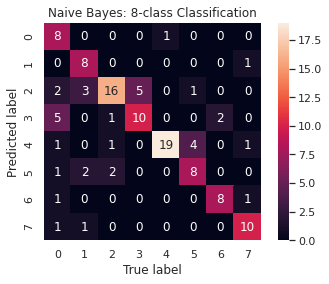

Accuracy:	0.701613
F1-score:	0.699433
Precision:	0.738177
Recall:		0.699220

Classification performance of [Multinomial] Naives Bayes Model:
               precision    recall  f1-score   support

        admin       0.89      0.42      0.57        19
    corporate       0.89      0.57      0.70        14
     criminal       0.59      0.80      0.68        20
 human rights       0.56      0.67      0.61        15
  immigration       0.73      0.95      0.83        20
international       0.62      0.62      0.62        13
       labour       0.80      0.80      0.80        10
          tax       0.83      0.77      0.80        13

     accuracy                           0.70       124
    macro avg       0.74      0.70      0.70       124
 weighted avg       0.73      0.70      0.70       124



In [65]:
# Plot the confusion matrix for model 1: Multinomial Naive Bayes classifier
mat1_nb = confusion_matrix(test_label, predicted_categories1_nb)
sns.heatmap(mat1_nb.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("Naive Bayes [Multinomial]: 8-class Classification")
plt.savefig("NB8_Multinomial_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predicted_categories1_nb))
print("F1-score:\t%f" % f1_score(test_label, predicted_categories1_nb, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predicted_categories1_nb, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predicted_categories1_nb, average='macro'))
print("\nClassification performance of [Multinomial] Naives Bayes Model:\n%s" % classification_report(test_label, predicted_categories1_nb))

### KNN CLASSIFIER

In [49]:
# Build the kNN model by setting a pipeline where the input is first converted
# to TF-IDF vectors and then a kNN classifier (default parameters) is deployed
model2_knn1 = make_pipeline(TfidfVectorizer(), KNeighborsClassifier())
model2_knn1.fit(train_text, train_label) # Train the model on the training data
predicted_categories2_knn1 = model2_knn1.predict(test_text) # Predict the categories of the test data
print("Predicted:",predicted_categories2_knn1.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",test_label[0:10]) # Print the first 10 ground truth values

Predicted: ['international', 'human rights', 'admin', 'tax', 'labour', 'admin', 'immigration', 'criminal', 'labour', 'criminal']
Ground truth: ['international', 'human rights', 'human rights', 'tax', 'labour', 'admin', 'immigration', 'criminal', 'labour', 'admin']


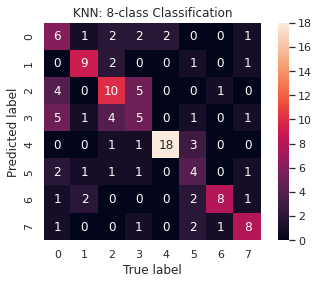

Accuracy:	0.548387
F1-score:	0.538736
Precision:	0.535552
Recall:		0.551882

Classification performance of KNN model (default):
               precision    recall  f1-score   support

        admin       0.43      0.32      0.36        19
    corporate       0.69      0.64      0.67        14
     criminal       0.50      0.50      0.50        20
 human rights       0.29      0.33      0.31        15
  immigration       0.78      0.90      0.84        20
international       0.40      0.31      0.35        13
       labour       0.57      0.80      0.67        10
          tax       0.62      0.62      0.62        13

     accuracy                           0.55       124
    macro avg       0.54      0.55      0.54       124
 weighted avg       0.54      0.55      0.54       124



In [50]:
# Plot the confusion matrix for model 2: KNN Classifier (KNN=1)
mat2_knn1 = confusion_matrix(test_label, predicted_categories2_knn1)
sns.heatmap(mat2_knn1.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("KNN: 8-class Classification")

plt.savefig("KNN_default_8_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predicted_categories2_knn1))
print("F1-score:\t%f" % f1_score(test_label, predicted_categories2_knn1, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predicted_categories2_knn1, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predicted_categories2_knn1, average='macro'))
print("\nClassification performance of KNN model (default):\n%s" % classification_report(test_label, predicted_categories2_knn1))

In [66]:
#selecting optimum k value
#creating a pipeline for vectorizing the data
vectorizer = TfidfVectorizer()
train_text_vectorized = vectorizer.fit_transform(train_text)

#originally the same pipeline was used for fitting and cross validation.
#this resulted in identical KNN scores for increasing k values.
#this was debugged by separating the pipeline into two: 
### 1. the data was vectorized using TfidfVectorizer()
### 2. it was vectorized again to fit and cross-validate the KNN model.

k_values = range(1, 20)
mean_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, train_text_vectorized, train_label, cv=5, error_score="raise")
    print("k:", k, "Score:", score.mean())
    mean_scores.append(score.mean())
    
#code adapted from: https://www.datacamp.com/tutorial/k-nearest-neighbor-classification-scikit-learn

k: 1 Score: 0.8203125
k: 2 Score: 0.78125
k: 3 Score: 0.765625
k: 4 Score: 0.7421875
k: 5 Score: 0.7203125
k: 6 Score: 0.6984375
k: 7 Score: 0.715625
k: 8 Score: 0.709375
k: 9 Score: 0.71875
k: 10 Score: 0.7046875
k: 11 Score: 0.70625
k: 12 Score: 0.6984375
k: 13 Score: 0.696875
k: 14 Score: 0.6984375
k: 15 Score: 0.696875
k: 16 Score: 0.6921875
k: 17 Score: 0.6984375
k: 18 Score: 0.696875
k: 19 Score: 0.703125


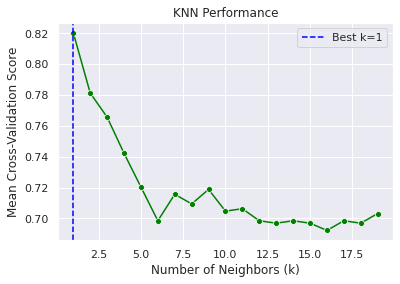

In [67]:
#to plot the highest performing k value
max_score = np.argmax(mean_scores)
high_k = k_values[max_score]

sns.set(style="dark")
sns.lineplot(x=k_values, y=mean_scores, marker='o', color="green")

plt.axvline(x=high_k, color='blue', linestyle='--', label=f'Best k={high_k}')
plt.legend()

plt.title('KNN Performance')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Cross-Validation Score')
plt.savefig('optimal_k_8_performance.png')

plt.grid(True)
plt.show()

In [68]:
# Build the kNN model by setting a pipeline where the input is first converted
# to TF-IDF vectors and then a kNN classifier for k=1 is used
model2_knn1 = make_pipeline(TfidfVectorizer(), KNeighborsClassifier(n_neighbors=1))
model2_knn1.fit(train_text, train_label) # Train the model on the training data
predicted_categories2_knn1 = model2_knn1.predict(test_text) # Predict the categories of the test data
print("Predicted:",predicted_categories2_knn1.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",test_label[0:10]) # Print the first 10 ground truth values

Predicted: ['immigration', 'human rights', 'admin', 'tax', 'criminal', 'human rights', 'immigration', 'criminal', 'labour', 'criminal']
Ground truth: ['international', 'human rights', 'human rights', 'tax', 'labour', 'admin', 'immigration', 'criminal', 'labour', 'admin']


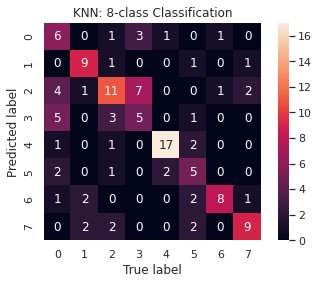

Accuracy:	0.564516
F1-score:	0.559508
Precision:	0.563897
Recall:		0.571113

Classification performance of KNN model (k=1):
               precision    recall  f1-score   support

        admin       0.50      0.32      0.39        19
    corporate       0.75      0.64      0.69        14
     criminal       0.42      0.55      0.48        20
 human rights       0.36      0.33      0.34        15
  immigration       0.81      0.85      0.83        20
international       0.50      0.38      0.43        13
       labour       0.57      0.80      0.67        10
          tax       0.60      0.69      0.64        13

     accuracy                           0.56       124
    macro avg       0.56      0.57      0.56       124
 weighted avg       0.56      0.56      0.56       124



In [69]:
# Plot the confusion matrix for model 2: KNN Classifier (KNN=1)
mat2_knn1 = confusion_matrix(test_label, predicted_categories2_knn1)
sns.heatmap(mat2_knn1.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("KNN (k=1): 8-class Classification")

plt.savefig("KNN1_8_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predicted_categories2_knn1))
print("F1-score:\t%f" % f1_score(test_label, predicted_categories2_knn1, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predicted_categories2_knn1, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predicted_categories2_knn1, average='macro'))
print("\nClassification performance of KNN model (k=1):\n%s" % classification_report(test_label, predicted_categories2_knn1))

### SVM Classifier

In [70]:
# Build the SVM model by setting a pipeline where the input is first converted
#kernel=linear which is recommended for text classification
model3_svm = make_pipeline(TfidfVectorizer(), svm.SVC(kernel="linear"))

model3_svm.fit(train_text, train_label) # Train the model on the training data
                                                      
predicted_categories3_svm = model3_svm.predict(test_text) # Predict the categories of the test data
print("Predicted:",predicted_categories3_svm.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",test_label[0:10]) # Print the first 10 ground truth values

Predicted: ['international', 'human rights', 'admin', 'tax', 'admin', 'human rights', 'international', 'criminal', 'labour', 'criminal']
Ground truth: ['international', 'human rights', 'human rights', 'tax', 'labour', 'admin', 'immigration', 'criminal', 'labour', 'admin']


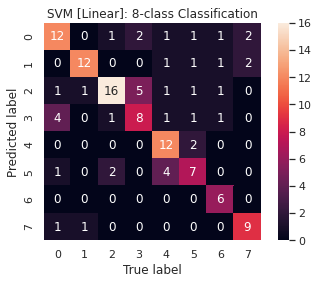

Accuracy:	0.661290
F1-score:	0.665720
Precision:	0.699574
Recall:		0.656603

Classification performance of SVM (kernel=linear):
               precision    recall  f1-score   support

        admin       0.60      0.63      0.62        19
    corporate       0.71      0.86      0.77        14
     criminal       0.62      0.80      0.70        20
 human rights       0.50      0.53      0.52        15
  immigration       0.86      0.60      0.71        20
international       0.50      0.54      0.52        13
       labour       1.00      0.60      0.75        10
          tax       0.82      0.69      0.75        13

     accuracy                           0.66       124
    macro avg       0.70      0.66      0.67       124
 weighted avg       0.69      0.66      0.66       124



In [71]:
#plot the confusion matrix for model 3: SVM, kernel=linear
mat3_svm = confusion_matrix(test_label, predicted_categories3_svm)
sns.heatmap(mat3_svm.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("SVM [Linear]: 8-class Classification")
plt.savefig("SVM_Linear_8_Performance")
plt.show()

#compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predicted_categories3_svm))
print("F1-score:\t%f" % f1_score(test_label, predicted_categories3_svm, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predicted_categories3_svm, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predicted_categories3_svm, average='macro'))
print("\nClassification performance of SVM (kernel=linear):\n%s" % classification_report(test_label, predicted_categories3_svm))

In [72]:
#kernel=rbf to test non-linearity between features and class
model3_svm2 = make_pipeline(TfidfVectorizer(), svm.SVC(kernel="rbf"))

model3_svm2.fit(train_text, train_label) # Train the model on the training data
                                                      
predicted_categories3_svm2 = model3_svm2.predict(test_text) # Predict the categories of the test data
print("Predicted:",predicted_categories3_svm2.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",test_label[0:10]) # Print the first 10 ground truth values

Predicted: ['international', 'human rights', 'admin', 'tax', 'criminal', 'criminal', 'international', 'criminal', 'labour', 'criminal']
Ground truth: ['international', 'human rights', 'human rights', 'tax', 'labour', 'admin', 'immigration', 'criminal', 'labour', 'admin']


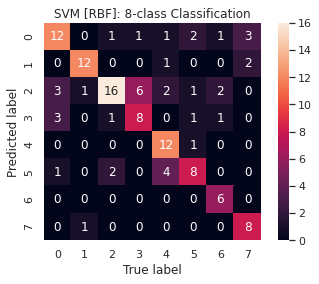

Accuracy:	0.661290
F1-score:	0.672842
Precision:	0.725536
Recall:		0.656603

Classification performance of SVM model (kernel=rbf):
               precision    recall  f1-score   support

        admin       0.57      0.63      0.60        19
    corporate       0.80      0.86      0.83        14
     criminal       0.52      0.80      0.63        20
 human rights       0.57      0.53      0.55        15
  immigration       0.92      0.60      0.73        20
international       0.53      0.62      0.57        13
       labour       1.00      0.60      0.75        10
          tax       0.89      0.62      0.73        13

     accuracy                           0.66       124
    macro avg       0.73      0.66      0.67       124
 weighted avg       0.71      0.66      0.67       124



In [73]:
#plot the confusion matrix for model 3: SVM, kernel=rbf
mat3_svm2 = confusion_matrix(test_label, predicted_categories3_svm2)
sns.heatmap(mat3_svm2.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("SVM [RBF]: 8-class Classification")

plt.savefig("SVM_rbf_8_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predicted_categories3_svm2))
print("F1-score:\t%f" % f1_score(test_label, predicted_categories3_svm2, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predicted_categories3_svm2, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predicted_categories3_svm2, average='macro'))
print("\nClassification performance of SVM model (kernel=rbf):\n%s" % classification_report(test_label, predicted_categories3_svm2))

In [74]:
#kernel=poly (polynomial) to test non-linearity between features and class
model3_svm3 = make_pipeline(TfidfVectorizer(), svm.SVC(kernel="poly"))

model3_svm3.fit(train_text, train_label) # Train the model on the training data
                                                      
predicted_categories3_svm3 = model3_svm3.predict(test_text) # Predict the categories of the test data
print("Predicted:",predicted_categories3_svm3.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",test_label[0:10]) # Print the first 10 ground truth values

Predicted: ['criminal', 'human rights', 'admin', 'tax', 'criminal', 'criminal', 'criminal', 'criminal', 'criminal', 'criminal']
Ground truth: ['international', 'human rights', 'human rights', 'tax', 'labour', 'admin', 'immigration', 'criminal', 'labour', 'admin']


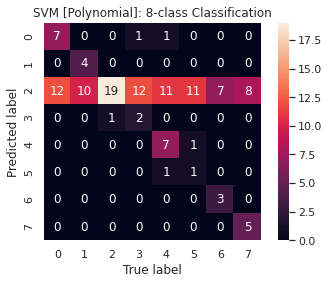

Accuracy:	0.387097
F1-score:	0.395319
Precision:	0.753819
Recall:		0.356126

Classification performance of SVM model (kernel=poly):
               precision    recall  f1-score   support

        admin       0.78      0.37      0.50        19
    corporate       1.00      0.29      0.44        14
     criminal       0.21      0.95      0.35        20
 human rights       0.67      0.13      0.22        15
  immigration       0.88      0.35      0.50        20
international       0.50      0.08      0.13        13
       labour       1.00      0.30      0.46        10
          tax       1.00      0.38      0.56        13

     accuracy                           0.39       124
    macro avg       0.75      0.36      0.40       124
 weighted avg       0.73      0.39      0.40       124



In [75]:
#plot the confusion matrix for model 3: SVM, kernel="poly"
mat3_svm3 = confusion_matrix(test_label, predicted_categories3_svm3)
sns.heatmap(mat3_svm3.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("SVM [Polynomial]: 8-class Classification")

plt.savefig("SVM_poly_8_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predicted_categories3_svm3))
print("F1-score:\t%f" % f1_score(test_label, predicted_categories3_svm3, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predicted_categories3_svm3, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predicted_categories3_svm3, average='macro'))
print("\nClassification performance of SVM model (kernel=poly):\n%s" % classification_report(test_label, predicted_categories3_svm3))

In [53]:
#dict with hyperparameter values
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__degree': [2, 3, 4]
}

#svm with kernel=poly
model3_svm3_poly = make_pipeline(TfidfVectorizer(), svm.SVC(kernel="poly"))

#grid search with cross-validation=5
grid_search = GridSearchCV(model3_svm3_poly, param_grid, cv=5)
grid_search.fit(train_text, train_label)

best_degree = grid_search.best_params_['svc__degree']
best_C = grid_search.best_params_['svc__C']

#code guided by https://aneesha.medium.com/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0

In [54]:
print("The best degree for SVM with Polynomial kernel: ", best_degree)
print("The best C for SVM with Polynomial kernel: ", best_C)

The best degree for SVM with Polynomial kernel:  2
The best C for SVM with Polynomial kernel:  10


In [55]:
#kernel=poly (polynomial) to test non-linearity between features and class
#with 4 degrees
model3_svm3 = make_pipeline(TfidfVectorizer(), svm.SVC(kernel="poly", degree=2, C=10))

model3_svm3.fit(train_text, train_label) # Train the model on the training data
                                                      
predicted_categories3_svm3 = model3_svm3.predict(test_text) # Predict the categories of the test data
print("Predicted:",predicted_categories3_svm3.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",test_label[0:10]) # Print the first 10 ground truth values

Predicted: ['international', 'human rights', 'admin', 'tax', 'criminal', 'admin', 'immigration', 'criminal', 'labour', 'criminal']
Ground truth: ['international', 'human rights', 'human rights', 'tax', 'labour', 'admin', 'immigration', 'criminal', 'labour', 'admin']


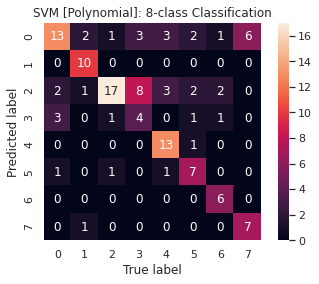

Accuracy:	0.620968
F1-score:	0.635198
Precision:	0.726080
Recall:		0.605261

Classification performance of (tuned) SVM model (kernel=poly):
               precision    recall  f1-score   support

        admin       0.42      0.68      0.52        19
    corporate       1.00      0.71      0.83        14
     criminal       0.49      0.85      0.62        20
 human rights       0.40      0.27      0.32        15
  immigration       0.93      0.65      0.76        20
international       0.70      0.54      0.61        13
       labour       1.00      0.60      0.75        10
          tax       0.88      0.54      0.67        13

     accuracy                           0.62       124
    macro avg       0.73      0.61      0.64       124
 weighted avg       0.70      0.62      0.63       124



In [56]:
#plot the confusion matrix for model 3: SVM, kernel="poly"
mat3_svm3 = confusion_matrix(test_label, predicted_categories3_svm3)
sns.heatmap(mat3_svm3.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("SVM [Polynomial]: 8-class Classification")

plt.savefig("SVM_poly_8_tuned_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predicted_categories3_svm3))
print("F1-score:\t%f" % f1_score(test_label, predicted_categories3_svm3, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predicted_categories3_svm3, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predicted_categories3_svm3, average='macro'))
print("\nClassification performance of (tuned) SVM model (kernel=poly):\n%s" % classification_report(test_label, predicted_categories3_svm3))

### Decision Tree

In [76]:
#build the DCT model by setting a pipeline where the input is first converted to tfid
#model built on default parameters, except criterion="entropy"
model6_dt = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier(criterion="entropy"))

model6_dt.fit(train_text, train_label) # Train the model on the training data
                                                      
predicted_categories6_dt = model6_dt.predict(test_text) # Predict the categories of the test data
print("Predicted:",predicted_categories6_dt.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",test_label[0:10]) # Print the first 10 ground truth values

Predicted: ['corporate', 'human rights', 'criminal', 'tax', 'corporate', 'corporate', 'human rights', 'criminal', 'international', 'criminal']
Ground truth: ['international', 'human rights', 'human rights', 'tax', 'labour', 'admin', 'immigration', 'criminal', 'labour', 'admin']


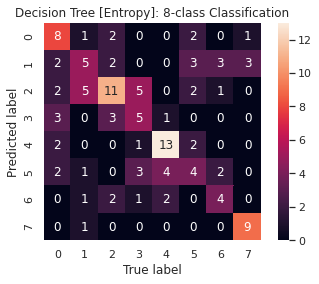

Accuracy:	0.475806
F1-score:	0.473583
Precision:	0.495147
Recall:		0.463941

Classification performance of Decision Tree:
               precision    recall  f1-score   support

        admin       0.57      0.42      0.48        19
    corporate       0.28      0.36      0.31        14
     criminal       0.42      0.55      0.48        20
 human rights       0.42      0.33      0.37        15
  immigration       0.72      0.65      0.68        20
international       0.25      0.31      0.28        13
       labour       0.40      0.40      0.40        10
          tax       0.90      0.69      0.78        13

     accuracy                           0.48       124
    macro avg       0.50      0.46      0.47       124
 weighted avg       0.51      0.48      0.49       124



In [77]:
# Plot the confusion matrix for model 6: Decision Tree
model6_dt = confusion_matrix(test_label, predicted_categories6_dt)
sns.heatmap(model6_dt.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("Decision Tree [Entropy]: 8-class Classification")

plt.savefig("4 DecisionT_EntropyDefault_8_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predicted_categories6_dt))
print("F1-score:\t%f" % f1_score(test_label, predicted_categories6_dt, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predicted_categories6_dt, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predicted_categories6_dt, average='macro'))
print("\nClassification performance of Decision Tree:\n%s" % classification_report(test_label, predicted_categories6_dt))

In [78]:
#build the DCT model by setting a pipeline where the input is first converted to tfid
#model built on all default parameters (criterion="gini")
model6_dt = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier())

model6_dt.fit(train_text, train_label) # Train the model on the training data
                                                      
predicted_categories6_dt = model6_dt.predict(test_text) # Predict the categories of the test data
print("Predicted:",predicted_categories6_dt.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",test_label[0:10]) # Print the first 10 ground truth values

Predicted: ['admin', 'international', 'criminal', 'tax', 'labour', 'international', 'admin', 'criminal', 'labour', 'criminal']
Ground truth: ['international', 'human rights', 'human rights', 'tax', 'labour', 'admin', 'immigration', 'criminal', 'labour', 'admin']


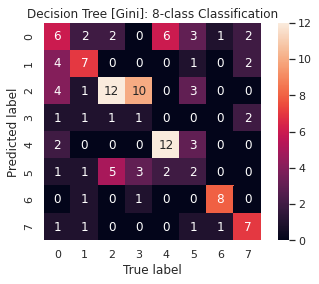

Accuracy:	0.443548
F1-score:	0.443506
Precision:	0.453062
Recall:		0.446845

Classification performance of Decision Tree:
               precision    recall  f1-score   support

        admin       0.27      0.32      0.29        19
    corporate       0.50      0.50      0.50        14
     criminal       0.40      0.60      0.48        20
 human rights       0.17      0.07      0.10        15
  immigration       0.71      0.60      0.65        20
international       0.14      0.15      0.15        13
       labour       0.80      0.80      0.80        10
          tax       0.64      0.54      0.58        13

     accuracy                           0.44       124
    macro avg       0.45      0.45      0.44       124
 weighted avg       0.44      0.44      0.44       124



In [79]:
# Plot the confusion matrix for model 6: Decision Tree
model6_dt = confusion_matrix(test_label, predicted_categories6_dt)
sns.heatmap(model6_dt.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("Decision Tree [Gini]: 8-class Classification")

plt.savefig("4a DecisionT_Gini_8_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predicted_categories6_dt))
print("F1-score:\t%f" % f1_score(test_label, predicted_categories6_dt, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predicted_categories6_dt, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predicted_categories6_dt, average='macro'))
print("\nClassification performance of Decision Tree:\n%s" % classification_report(test_label, predicted_categories6_dt))

In [80]:
#hyperparameter tuning
#specifying hyperparameter ranges
param_dist = {'decisiontreeclassifier__max_depth': randint(1, 20),
              'decisiontreeclassifier__min_samples_split': randint(2, 20),
              'decisiontreeclassifier__min_samples_leaf': randint(1, 10)}

dt_pipeline = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier())

#find best hyperparameters through random search
rand_search = RandomizedSearchCV(dt_pipeline,
                                 param_distributions=param_dist,
                                 n_iter=10,
                                 cv=5)

#fit rand_search to the data
rand_search.fit(train_text, train_label)

#adapted from otaviomguerra/decision_tree_with_RandomizedSearch.py at https://gist.github.com/otaviomguerra/51df7a4cff28f92de7105f12a0724115
#adapted from https://www.datacamp.com/tutorial/random-forests-classifier-python

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidfvectorizer',
                                              TfidfVectorizer()),
                                             ('decisiontreeclassifier',
                                              DecisionTreeClassifier())]),
                   param_distributions={'decisiontreeclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9d356f4a90>,
                                        'decisiontreeclassifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9d37426280>,
                                        'decisiontreeclassifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9d3740d670>})

In [81]:
#creating variable for the best model
best_dt = rand_search.best_estimator_

#identify the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

#adapted from https://www.datacamp.com/tutorial/random-forests-classifier-python

Best hyperparameters: {'decisiontreeclassifier__max_depth': 13, 'decisiontreeclassifier__min_samples_leaf': 3, 'decisiontreeclassifier__min_samples_split': 3}


In [90]:
#rerunning Decision Tree algorithm with tuned parameters

model6_dt2 = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier(max_depth=13, min_samples_leaf=3, min_samples_split=3))

model6_dt2.fit(train_text, train_label) # Train the model on the training data
                                                      
predicted_categories6_dt2 = model6_dt2.predict(test_text) # Predict the categories of the test data
print("Predicted:",predicted_categories6_dt2.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",test_label[0:10]) # Print the first 10 ground truth values

Predicted: ['admin', 'international', 'criminal', 'tax', 'labour', 'international', 'admin', 'criminal', 'labour', 'criminal']
Ground truth: ['international', 'human rights', 'human rights', 'tax', 'labour', 'admin', 'immigration', 'criminal', 'labour', 'admin']


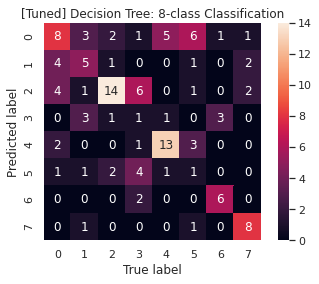

Accuracy:	0.451613
F1-score:	0.437601
Precision:	0.453279
Recall:		0.435896

Classification performance of (Tuned) Decision Tree:
               precision    recall  f1-score   support

        admin       0.30      0.42      0.35        19
    corporate       0.38      0.36      0.37        14
     criminal       0.50      0.70      0.58        20
 human rights       0.11      0.07      0.08        15
  immigration       0.68      0.65      0.67        20
international       0.10      0.08      0.09        13
       labour       0.75      0.60      0.67        10
          tax       0.80      0.62      0.70        13

     accuracy                           0.45       124
    macro avg       0.45      0.44      0.44       124
 weighted avg       0.45      0.45      0.44       124



In [91]:
# Plot the confusion matrix for model 6: tuned Decision Tree
model6_dt2 = confusion_matrix(test_label, predicted_categories6_dt2)
sns.heatmap(model6_dt2.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("[Tuned] Decision Tree: 8-class Classification")
plt.savefig("DecisionT_HyperGini_8_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predicted_categories6_dt2))
print("F1-score:\t%f" % f1_score(test_label, predicted_categories6_dt2, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predicted_categories6_dt2, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predicted_categories6_dt2, average='macro'))
print("\nClassification performance of (Tuned) Decision Tree:\n%s" % classification_report(test_label, predicted_categories6_dt2))

In [92]:
#rerunning Decision Tree algorithm with tuned parameters + entropy

model6_dt3 = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier(max_depth=13, min_samples_leaf=3, min_samples_split=3, criterion="entropy"))

model6_dt3.fit(train_text, train_label) # Train the model on the training data
                                                      
predicted_categories6_dt3 = model6_dt3.predict(test_text) # Predict the categories of the test data
print("Predicted:",predicted_categories6_dt3.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",test_label[0:10]) # Print the first 10 ground truth values

Predicted: ['international', 'human rights', 'admin', 'tax', 'corporate', 'corporate', 'international', 'criminal', 'admin', 'criminal']
Ground truth: ['international', 'human rights', 'human rights', 'tax', 'labour', 'admin', 'immigration', 'criminal', 'labour', 'admin']


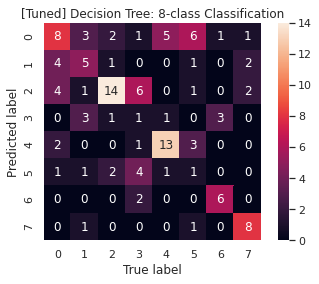

Accuracy:	0.491935
F1-score:	0.476157
Precision:	0.488003
Recall:		0.475825

Classification performance of (Tuned) Decision Tree (Entropy):
               precision    recall  f1-score   support

        admin       0.44      0.58      0.50        19
    corporate       0.31      0.36      0.33        14
     criminal       0.62      0.40      0.48        20
 human rights       0.39      0.47      0.42        15
  immigration       0.65      0.65      0.65        20
international       0.46      0.46      0.46        13
       labour       0.29      0.20      0.24        10
          tax       0.75      0.69      0.72        13

     accuracy                           0.49       124
    macro avg       0.49      0.48      0.48       124
 weighted avg       0.50      0.49      0.49       124



In [93]:
# Plot the confusion matrix for model 6: tuned Decision Tree + entropy
model6_dt3 = confusion_matrix(test_label, predicted_categories6_dt2)
sns.heatmap(model6_dt3.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("[Tuned] Decision Tree: 8-class Classification")

plt.savefig("DecisionT_Tuned_Entropy 8_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predicted_categories6_dt3))
print("F1-score:\t%f" % f1_score(test_label, predicted_categories6_dt3, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predicted_categories6_dt3, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predicted_categories6_dt3, average='macro'))
print("\nClassification performance of (Tuned) Decision Tree (Entropy):\n%s" % classification_report(test_label, predicted_categories6_dt3))

### Random Forest Classifier

In [86]:
# Build the RF model by setting a pipeline where the input is first converted
#no number of trees is specified: modl is run using default (100)
model4_rf = make_pipeline(TfidfVectorizer(), RandomForestClassifier())

model4_rf.fit(train_text, train_label) # Train the model on the training data
                                                      
predicted_categories4_rf = model4_rf.predict(test_text) # Predict the categories of the test data
print("Predicted:",predicted_categories4_rf.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",test_label[0:10]) # Print the first 10 ground truth values

Predicted: ['criminal', 'human rights', 'human rights', 'tax', 'labour', 'admin', 'immigration', 'criminal', 'labour', 'criminal']
Ground truth: ['international', 'human rights', 'human rights', 'tax', 'labour', 'admin', 'immigration', 'criminal', 'labour', 'admin']


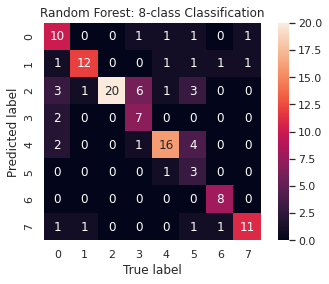

Accuracy:	0.701613
F1-score:	0.684507
Precision:	0.745646
Recall:		0.690881

Classification performance of Random Forest Classifier:
               precision    recall  f1-score   support

        admin       0.71      0.53      0.61        19
    corporate       0.71      0.86      0.77        14
     criminal       0.59      1.00      0.74        20
 human rights       0.78      0.47      0.58        15
  immigration       0.70      0.80      0.74        20
international       0.75      0.23      0.35        13
       labour       1.00      0.80      0.89        10
          tax       0.73      0.85      0.79        13

     accuracy                           0.70       124
    macro avg       0.75      0.69      0.68       124
 weighted avg       0.73      0.70      0.68       124



In [94]:
#plot the confusion matrix for model 4: Random Forest (default no.of trees)
mat4_rf = confusion_matrix(test_label, predicted_categories4_rf)
sns.heatmap(mat4_rf.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("Random Forest: 8-class Classification")

plt.savefig("RF_8_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predicted_categories4_rf))
print("F1-score:\t%f" % f1_score(test_label, predicted_categories4_rf, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predicted_categories4_rf, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predicted_categories4_rf, average='macro'))
print("\nClassification performance of Random Forest Classifier:\n%s" % classification_report(test_label, predicted_categories4_rf))


In [88]:
#randomint to 1000 (50,1000)
#define hyperparameter ranges
param_dist = {'randomforestclassifier__n_estimators': randint(50, 1000),
              'randomforestclassifier__max_depth': randint(1, 20)}

# Create a random forest classifier pipeline
rf_pipeline = make_pipeline(TfidfVectorizer(), RandomForestClassifier())

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf_pipeline,
                                 param_distributions=param_dist,
                                 n_iter=10,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(train_text, train_label)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidfvectorizer',
                                              TfidfVectorizer()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier())]),
                   param_distributions={'randomforestclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9d35488e50>,
                                        'randomforestclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9d3548eaf0>})

In [89]:
#variable for the best model
best_rf = rand_search.best_estimator_

#print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

#code adapted from: https://www.datacamp.com/tutorial/random-forests-classifier-python

Best hyperparameters: {'randomforestclassifier__max_depth': 7, 'randomforestclassifier__n_estimators': 579}


In [95]:
#build the RF model by setting a pipeline where the input is first converted
#no.of trees=579
model4_rf2 = make_pipeline(TfidfVectorizer(), RandomForestClassifier(n_estimators=579, max_depth=7))

model4_rf2.fit(train_text, train_label) # Train the model on the training data
                                                      
predicted_categories4_rf2 = model4_rf2.predict(test_text) # Predict the categories of the test data
print("Predicted:",predicted_categories4_rf2.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",test_label[0:10]) # Print the first 10 ground truth values

Predicted: ['international', 'criminal', 'human rights', 'tax', 'labour', 'admin', 'immigration', 'criminal', 'labour', 'criminal']
Ground truth: ['international', 'human rights', 'human rights', 'tax', 'labour', 'admin', 'immigration', 'criminal', 'labour', 'admin']


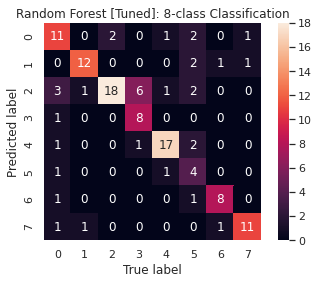

Accuracy:	0.717742
F1-score:	0.706099
Precision:	0.741062
Recall:		0.709159

Classification performance of Random Forest Classifier (No.of Trees=579):
               precision    recall  f1-score   support

        admin       0.65      0.58      0.61        19
    corporate       0.75      0.86      0.80        14
     criminal       0.58      0.90      0.71        20
 human rights       0.89      0.53      0.67        15
  immigration       0.81      0.85      0.83        20
international       0.67      0.31      0.42        13
       labour       0.80      0.80      0.80        10
          tax       0.79      0.85      0.81        13

     accuracy                           0.72       124
    macro avg       0.74      0.71      0.71       124
 weighted avg       0.73      0.72      0.71       124



In [96]:
#plot the confusion matrix for model 4: Random Forest (no.of trees=407)
mat4_rf2 = confusion_matrix(test_label, predicted_categories4_rf2)
sns.heatmap(mat4_rf2.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("Random Forest [Tuned]: 8-class Classification")

plt.savefig("RF579_8_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predicted_categories4_rf2))
print("F1-score:\t%f" % f1_score(test_label, predicted_categories4_rf2, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predicted_categories4_rf2, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predicted_categories4_rf2, average='macro'))
print("\nClassification performance of Random Forest Classifier (No.of Trees=579):\n%s" % classification_report(test_label, predicted_categories4_rf2))

### Logistic Regression

In [97]:
from sklearn.linear_model import LogisticRegression
# Build the LR model by setting a pipeline where the input is first converted
#to tfid
model5_lr = make_pipeline(TfidfVectorizer(), LogisticRegression())

model5_lr.fit(train_text, train_label) # Train the model on the training data
                                                      
predicted_categories5_lr = model5_lr.predict(test_text) # Predict the categories of the test data
print("Predicted:",predicted_categories5_lr.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",test_label[0:10]) # Print the first 10 ground truth values

Predicted: ['international', 'human rights', 'admin', 'tax', 'labour', 'human rights', 'international', 'criminal', 'labour', 'criminal']
Ground truth: ['international', 'human rights', 'human rights', 'tax', 'labour', 'admin', 'immigration', 'criminal', 'labour', 'admin']


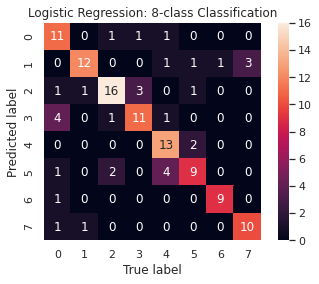

Accuracy:	0.733871
F1-score:	0.741202
Precision:	0.748652
Recall:		0.747620

Classification performance of Logistic Regression:
               precision    recall  f1-score   support

        admin       0.79      0.58      0.67        19
    corporate       0.67      0.86      0.75        14
     criminal       0.73      0.80      0.76        20
 human rights       0.65      0.73      0.69        15
  immigration       0.87      0.65      0.74        20
international       0.56      0.69      0.62        13
       labour       0.90      0.90      0.90        10
          tax       0.83      0.77      0.80        13

     accuracy                           0.73       124
    macro avg       0.75      0.75      0.74       124
 weighted avg       0.75      0.73      0.73       124



In [98]:
# Plot the confusion matrix for model 5: Logistic Regression
mat5_lr = confusion_matrix(test_label, predicted_categories5_lr)
sns.heatmap(mat5_lr.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("Logistic Regression: 8-class Classification")

plt.savefig("LogReg_8_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predicted_categories5_lr))
print("F1-score:\t%f" % f1_score(test_label, predicted_categories5_lr, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predicted_categories5_lr, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predicted_categories5_lr, average='macro'))
print("\nClassification performance of Logistic Regression:\n%s" % classification_report(test_label, predicted_categories5_lr))

### Gradient Boosting Classifier 

In [99]:
# Build the GB classifier by setting a pipeline where the input is first converted
#to tfid
model7_gbc = make_pipeline(TfidfVectorizer(), GradientBoostingClassifier())

model7_gbc.fit(train_text, train_label) # Train the model on the training data
                                                      
predicted_categories7_gbc = model7_gbc.predict(test_text) # Predict the categories of the test data
print("Predicted:",predicted_categories7_gbc.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",test_label[0:10]) # Print the first 10 ground truth values

Predicted: ['criminal', 'human rights', 'admin', 'tax', 'labour', 'admin', 'immigration', 'criminal', 'international', 'criminal']
Ground truth: ['international', 'human rights', 'human rights', 'tax', 'labour', 'admin', 'immigration', 'criminal', 'labour', 'admin']


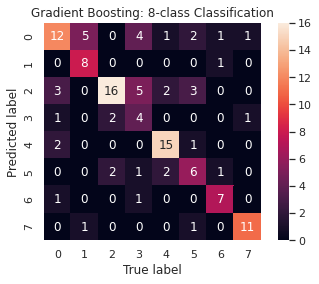

Accuracy:	0.637097
F1-score:	0.635293
Precision:	0.669927
Recall:		0.628421

Classification performance of Gradient Boosting Classifier:
               precision    recall  f1-score   support

        admin       0.46      0.63      0.53        19
    corporate       0.89      0.57      0.70        14
     criminal       0.55      0.80      0.65        20
 human rights       0.50      0.27      0.35        15
  immigration       0.83      0.75      0.79        20
international       0.50      0.46      0.48        13
       labour       0.78      0.70      0.74        10
          tax       0.85      0.85      0.85        13

     accuracy                           0.64       124
    macro avg       0.67      0.63      0.64       124
 weighted avg       0.66      0.64      0.63       124



In [100]:
# Plot the confusion matrix for model 7: Gradient Boosting classifier
model7_gbc = confusion_matrix(test_label, predicted_categories7_gbc)
sns.heatmap(model7_gbc.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("Gradient Boosting: 8-class Classification")

plt.savefig("GBC_default_8_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predicted_categories7_gbc))
print("F1-score:\t%f" % f1_score(test_label, predicted_categories7_gbc, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predicted_categories7_gbc, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predicted_categories7_gbc, average='macro'))
print("\nClassification performance of Gradient Boosting Classifier:\n%s" % classification_report(test_label, predicted_categories7_gbc))

In [47]:
#test data for hyperparameter tuning

# Define hyperparameter ranges
param_dist = {'gradientboostingclassifier__n_estimators': randint(50, 1000),
              'gradientboostingclassifier__max_depth': randint(1, 20),
              'gradientboostingclassifier__min_samples_split': randint(2, 20),
              'gradientboostingclassifier__min_samples_leaf': randint(1, 10)
             }

# Create a random forest classifier pipeline
gbc_pipeline = make_pipeline(TfidfVectorizer(), GradientBoostingClassifier())

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(gbc_pipeline,
                                 param_distributions=param_dist,
                                 n_iter=5,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(train_text, train_label)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tfidfvectorizer',
                                              TfidfVectorizer()),
                                             ('gradientboostingclassifier',
                                              GradientBoostingClassifier())]),
                   n_iter=5,
                   param_distributions={'gradientboostingclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000157CC989F90>,
                                        'gradientboostingclassifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000157DAF26A70>,
                                        'gradientboostingclassifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000157DAB87460>,
                                        'gradientboostingclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000157DAB87550>})

In [48]:
#variable for the best model
best_gbc = rand_search.best_estimator_

#print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'gradientboostingclassifier__max_depth': 12, 'gradientboostingclassifier__min_samples_leaf': 8, 'gradientboostingclassifier__min_samples_split': 14, 'gradientboostingclassifier__n_estimators': 199}


In [49]:
# Build the GB classifier by setting a pipeline where the input is first converted
#to tfid
#hyperparameters tuned
model7_gbc2 = make_pipeline(TfidfVectorizer(), GradientBoostingClassifier(max_depth=12, min_samples_leaf=8, min_samples_split=14, n_estimators=199))

model7_gbc2.fit(train_text, train_label) # Train the model on the training data
                                                      
predicted_categories7_gbc2 = model7_gbc2.predict(test_text) # Predict the categories of the test data
print("Predicted:",predicted_categories7_gbc2.tolist()[0:10]) # Print the first 10 predictions
print("Ground truth:",test_label[0:10]) # Print the first 10 ground truth values

Predicted: ['human rights', 'criminal', 'human rights', 'tax', 'labour', 'admin', 'immigration', 'criminal', 'labour', 'criminal']
Ground truth: ['international', 'human rights', 'human rights', 'tax', 'labour', 'admin', 'immigration', 'criminal', 'labour', 'admin']


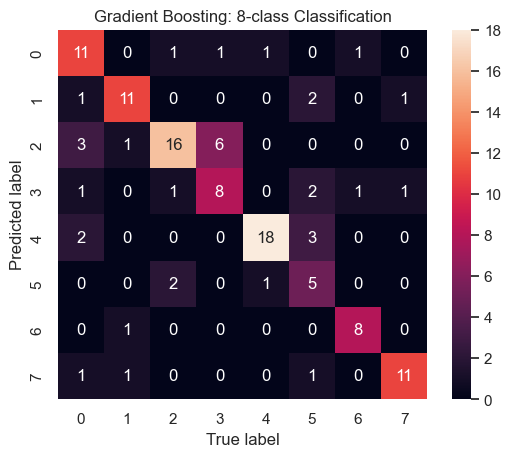

Accuracy:	0.709677
F1-score:	0.702922
Precision:	0.716961
Recall:		0.703596

Classification performance of Tuned Gradient Boosting Classifier:
               precision    recall  f1-score   support

        admin       0.73      0.58      0.65        19
    corporate       0.73      0.79      0.76        14
     criminal       0.62      0.80      0.70        20
 human rights       0.57      0.53      0.55        15
  immigration       0.78      0.90      0.84        20
international       0.62      0.38      0.48        13
       labour       0.89      0.80      0.84        10
          tax       0.79      0.85      0.81        13

     accuracy                           0.71       124
    macro avg       0.72      0.70      0.70       124
 weighted avg       0.71      0.71      0.70       124



In [50]:
# Plot the confusion matrix for model 7: tuned Gradient Boosting classifier
model7_gbc2 = confusion_matrix(test_label, predicted_categories7_gbc2)
sns.heatmap(model7_gbc2.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("Gradient Boosting: 8-class Classification")

plt.savefig("GBC_tuned_8_Performance2")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predicted_categories7_gbc2))
print("F1-score:\t%f" % f1_score(test_label, predicted_categories7_gbc2, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predicted_categories7_gbc2, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predicted_categories7_gbc2, average='macro'))
print("\nClassification performance of Tuned Gradient Boosting Classifier:\n%s" % classification_report(test_label, predicted_categories7_gbc2))

### Implementing Deep Learning: Neural Networks

#### Data Preprocessing

In [2]:
TEXT = data.Field(tokenize=word_tokenize,batch_first=True,include_lengths=True) # Create text field for dataset
LABEL = data.LabelField(dtype = torch.float,batch_first=True) # Create label field for dataset

fields = [('text',TEXT),('label', LABEL)]

In [ ]:
# Load dataset from csv file
dataset=data.TabularDataset(path = 'UKSC_training_data_NN_8labels.csv',format = 'csv',fields = fields,skip_header = True)
#print(vars(dataset.examples[0])) # Print first text as an example

In [4]:
#dividing data into training and test sets

import random
RANDOM_SEED = 42 # Set random seed for reproducibility.

# Divide dataset into a training set (80%) and a test set (20%)
training_data, test_data = dataset.split(split_ratio=0.8, random_state = random.seed(RANDOM_SEED))

print("Training samples:",len(training_data))
print("Test samples:",len(test_data))

Training samples: 512
Test samples: 128


In [20]:
#check class balance

#class counters (to account for string labels)
train_counts = {"immigration": 0, "criminal": 0, "human rights": 0, "corporate": 0, "international": 0, "tax": 0, "labour": 0, "admin": 0}
test_counts = {"immigration": 0, "criminal": 0, "human rights": 0, "corporate": 0, "international": 0, "tax": 0, "labour": 0, "admin": 0}

#can we see how the class balance is?

#count classes in training data
for i in training_data:
    label = i.label
    train_counts[label] += 1

#count classes in test data
for i in test_data:
    label = i.label
    test_counts[label] += 1
    
train_total = len(training_data)

print("The Number of classes in in Training Data are:")
for label, count in train_counts.items():
    percentage = (count/train_total)*100
    print(f"{count} ({percentage:.2f}%): {label}")

#the training classes are still not fully balanced, but the balance is not bad.
#However, this imbalance could affect the performance.
#Especially since the CNN performs poorly on the test data.

The Number of classes in in Training Data are:
63 (12.30%): immigration
61 (11.91%): criminal
64 (12.50%): human rights
64 (12.50%): corporate
68 (13.28%): international
62 (12.11%): tax
66 (12.89%): labour
64 (12.50%): admin


In [21]:
#creating vocabulary using training set

TEXT.build_vocab(training_data,min_freq=1) # Build vocabulary from training set. Consider words that occur at least 1 time
LABEL.build_vocab(training_data) # Build vocabulary for labels

print("Size of TEXT vocabulary:",len(TEXT.vocab)) # Number of unique tokens in vocabulary
print("Size of LABEL vocabulary:",len(LABEL.vocab),"\n") # Number of unique labels
print("Most common tokens:",TEXT.vocab.freqs.most_common(10),"\n") # Print the 10 most common tokens in the training set

# Print the index number for the unknown token (<unk>) and the token used for padding (<pad>)
print("Index of unknown word <unk>:",TEXT.vocab.stoi['<unk>'])
print("Index of padding word <pad>:",TEXT.vocab.stoi['<pad>'])
print()
print("Number assigned to label:", LABEL.vocab.stoi) #number assigned to each label


Size of TEXT vocabulary: 33747
Size of LABEL vocabulary: 8 

Most common tokens: [('court', 39545), ('would', 28947), ('case', 26198), ('section', 24877), ('law', 22940), ('para', 22298), ('lord', 21726), ('appeal', 20946), ('act', 20018), ('article', 18370)] 

Index of unknown word <unk>: 0
Index of padding word <pad>: 1

Number assigned to label: defaultdict(None, {'international': 0, 'labour': 1, 'admin': 2, 'corporate': 3, 'human rights': 4, 'immigration': 5, 'tax': 6, 'criminal': 7})


#### Defining Model Architecture

In [22]:
#defining model architecture 
#create two iterators for training and test data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Set device to GPU if cuda available, else CPU
print("Device:",device)

torch.manual_seed(RANDOM_SEED)

BATCH_SIZE = 32 #set batch size for training #why 32?

# Create data iterator for training and test sets
training_iterator, test_iterator = data.BucketIterator.splits(
    (training_data, test_data),
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text), #telling the BucketIterator the function it should use to group the data
    sort_within_batch=True, #sorts data within each mini batch
    device = device)

Device: cpu


In [23]:
#define multi-class accuracy metric
#accuracy is calculated by performing argmax to get the index of the max.value
#in the prediction for each element, and counting no.of times this equals the actual label
#the values are then averaged across the batch.
def multiclass_accuracy(preds, y):
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [59]:
training_iterator

In [60]:
batch = next(training_iterator.__iter__())
print(batch)
print()

#use batch as wrapper to bundle all attributes to one variable dictionary
print(batch.__dict__.keys())


[torchtext.legacy.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x15947]', '[torch.LongTensor of size 32]')
	[.label]:[torch.FloatTensor of size 32]

dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'text', 'label'])


In [61]:
#check whether the dataset attribute of "batch" variable == the training_data variable
batch.__dict__['dataset'], training_data, batch.__dict__['dataset']==training_data

(<torchtext.legacy.data.dataset.Dataset at 0x7f89cdfff7f0>,
 True)

In [63]:
training_data[0].__dict__.keys()

dict_keys(['text', 'label'])

In [64]:
training_data[0].__dict__['text'][:5]

['michaelmas', 'term', 'uksc', 'appeal', 'ewca']

### Deploying a Convolutional Neural Network

In [55]:
class LegalAreaCNN(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 embedding_dim, 
                 n_filters, 
                 filter_sizes, 
                 output_dim, 
                 dropout, 
                 pad_idx):
        
        super().__init__()
        
        #embedding layer
        self.embedding = nn.Embedding(vocab_size, 
                                      embedding_dim, 
                                      padding_idx = pad_idx)
        #convolutional layers
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        #fully connected layer
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        #dropout layer
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):   
        #text = text.permute(1, 0)
        embedded = self.embedding(text)     
        embedded = embedded.unsqueeze(1)       
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]    
        cat = self.dropout(torch.cat(pooled, dim = 1))
        return self.fc(cat)
    
#code adapted from: https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb
#and from https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/5%20-%20Multi-class%20Sentiment%20Analysis.ipynb

In [56]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = len(LABEL.vocab)
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = LegalAreaCNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [57]:
print(model)
def parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("\n CNN model trainable parameters:",parameters(model))

LegalAreaCNN(
  (embedding): Embedding(34714, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1))
  )
  (fc): Linear(in_features=300, out_features=8, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

 CNN model trainable parameters: 3594108


In [58]:
#identify optimizer and loss criterion
optimizer = optim.Adam(model.parameters()) # Use the Adam optimiser
#criterion = nn.BCELoss() # Use Binary Cross Entropy between the target and the output as the loss function
criterion = nn.CrossEntropyLoss()

In [59]:
#send model to device
model = model.to(device)
criterion = criterion.to(device)

In [60]:
#defining a training function
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        text, _ = batch.text  #unpack the tuple
        predictions = model(text) #.squeeze()
        #torch.LongTensor used to convert/make sure that batch.label is of the same data type
        #aspredictions. If not, "RuntimeError: expected scalar type Long but found Float"
        loss = criterion(predictions, batch.label.type(torch.LongTensor)) 
        acc = multiclass_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

#defining an evaluation function
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
         for batch in iterator:
            text, _ = batch.text  # Unpack the tuple
            predictions = model(text) #.squeeze()
            loss = criterion(predictions, batch.label.type(torch.LongTensor))
            acc = multiclass_accuracy(predictions, batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

#training and evaluating performance of CNN over 10 epochs
N_EPOCHS = 10 # 10 epochs
best_valid_loss = float('inf')
best_valid_acc = float('inf')
best_epoch = 0

#lists to store the loss and accuracy for training and validation for each epoch
epoch_loss_train = []
epoch_loss_valid = []
epoch_accuracy_train = []
epoch_accuracy_valid = []

for epoch in range(N_EPOCHS):
    print("Epoch %3d:" % epoch,end='')
    start = time.time()
    
    #train the model
    train_loss, train_acc = train(model, training_iterator, optimizer, criterion)
    epoch_loss_train.append(train_loss) #append training loss for each epoch
    epoch_accuracy_train.append(train_acc) #append training accuracy of each epoch
    
    #evaluate the model
    valid_loss, valid_acc = evaluate(model, test_iterator, criterion)
    epoch_loss_valid.append(valid_loss) #append validation loss for each epoch
    epoch_accuracy_valid.append(valid_acc) #append validation accuracy of each epoch
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_valid_acc = valid_acc
        best_epoch = epoch
        torch.save(model.state_dict(), 'CNN8_saved_weights.pt')
    print(" Train loss: %.3f | Train acuracy: %3.4f " % (train_loss,train_acc),end='')
    print("| Validation loss: %.3f | Validation acuracy: %3.4f" % (valid_loss,valid_acc),end='')
    print(" - %3.2f s" % (time.time()-start))
    
print("\nBest performance at epoch %d | Loss: %.3f | Accuracy: %3.4f" %
      (best_epoch,best_valid_loss,best_valid_acc))

Epoch   0: Train loss: 2.899 | Train acuracy: 0.1230 | Validation loss: 1.956 | Validation acuracy: 0.1562 - 416.05 s
Epoch   1: Train loss: 2.135 | Train acuracy: 0.2539 | Validation loss: 1.702 | Validation acuracy: 0.4297 - 387.78 s
Epoch   2: Train loss: 1.924 | Train acuracy: 0.3184 | Validation loss: 1.521 | Validation acuracy: 0.6172 - 377.44 s
Epoch   3: Train loss: 1.695 | Train acuracy: 0.3926 | Validation loss: 1.431 | Validation acuracy: 0.5938 - 367.49 s
Epoch   4: Train loss: 1.545 | Train acuracy: 0.4727 | Validation loss: 1.327 | Validation acuracy: 0.7031 - 380.66 s
Epoch   5: Train loss: 1.308 | Train acuracy: 0.5430 | Validation loss: 1.256 | Validation acuracy: 0.5547 - 370.21 s
Epoch   6: Train loss: 1.330 | Train acuracy: 0.5020 | Validation loss: 1.174 | Validation acuracy: 0.7266 - 374.71 s
Epoch   7: Train loss: 1.186 | Train acuracy: 0.5938 | Validation loss: 1.082 | Validation acuracy: 0.7500 - 383.28 s
Epoch   8: Train loss: 1.090 | Train acuracy: 0.6504 | V

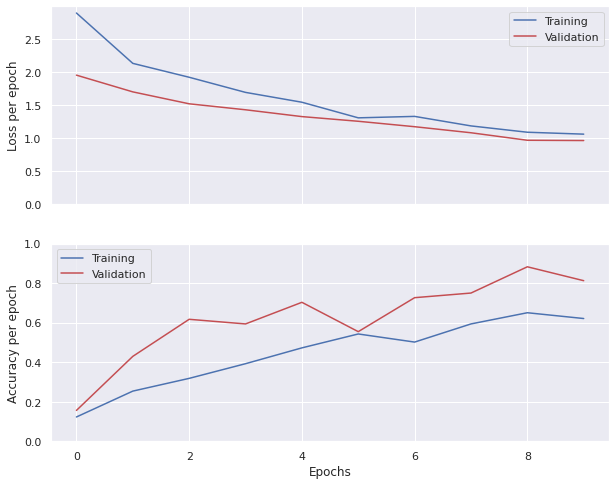

In [61]:
#one plot showing the training loss and validation loss
#another plot showing the training accuracy and validation accuracy

eps = np.arange(N_EPOCHS)

fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8), sharex=True)

#ax1.set_ylim([0, 1])
#to make the loss plot more visible
ax1.set_ylim([0, max(max(epoch_loss_train), max(epoch_loss_valid)) + 0.1])

ax1.plot(epoch_loss_train,'b')
ax1.plot(epoch_loss_valid,'r')
ax1.set_ylabel("Loss per epoch")
ax1.legend(["Training","Validation"])

ax2.set_ylim([0, 1])
ax2.plot(epoch_accuracy_train,'b')
ax2.plot(epoch_accuracy_valid,'r')
ax2.set_ylabel("Accuracy per epoch")
ax2.set_xlabel("Epochs");
ax2.legend(["Training","Validation"])

plt.savefig("Epoch loss_8labels")
plt.show()

In [62]:
max_words = 0
for sentence in train_text :
    max_words = max(len(sentence.split()), max_words )
print("There are a maximum of", max_words, "words in each training text")


There are a maximum of 34722 words in each training text


In [63]:
model.load_state_dict(torch.load('CNN8_saved_weights.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.964 | Test Acc: 81.25%


In [64]:
def LegalAreaCNN_predict(model, sentence, min_len = max_words):
    model.eval()
    #preprocess 
    tokenised = [token for token in word_tokenize(sentence)] # Tokenise text
    indexed = [TEXT.vocab.stoi[token] for token in tokenised]
    tensor = torch.LongTensor(indexed).to(device) # Convert to PyTorch tensor
    
    tensor = tensor.unsqueeze(0) # Reshape in form of batch,number of words
    prediction = model(tensor)
    prediction = prediction.argmax(dim = 1)
    return int(round(prediction.item()))

#code adapted from: https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb

In [85]:
label_names = {1:"labour", 2: "admin", 0: "international", 3: "corporate", 4: "human rights", 5: "immigration", 6: "tax", 7: "criminal" }
#Number assigned to label: defaultdict(None, {'international': 0, 'labour': 1, 'admin': 2, 'corporate': 3, 'human rights': 4, 'immigration': 5, 'tax': 6, 'criminal': 7})
    
predict_CNN_8 = []

for i in test_text:
    predict_label = label_names[LegalAreaCNN_predict(model, i)]
    predict_CNN_8.append(predict_label)
    
print("Predicted Label:",predict_CNN_8[0:10])
print("Ground Truth Label:",test_label[0:10])

Predicted Label: ['criminal', 'criminal', 'human rights', 'tax', 'criminal', 'criminal', 'human rights', 'criminal', 'labour', 'criminal']
Ground Truth Label: ['international', 'human rights', 'human rights', 'tax', 'labour', 'admin', 'immigration', 'criminal', 'labour', 'admin']


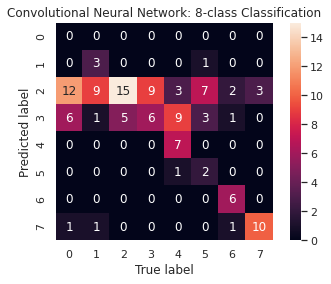

Accuracy:	0.395161
F1-score:	0.407119
Precision:	0.578681
Recall:		0.404670

Classification performance of CNN:
               precision    recall  f1-score   support

        admin       0.00      0.00      0.00        19
    corporate       0.75      0.21      0.33        14
     criminal       0.25      0.75      0.38        20
 human rights       0.19      0.40      0.26        15
  immigration       1.00      0.35      0.52        20
international       0.67      0.15      0.25        13
       labour       1.00      0.60      0.75        10
          tax       0.77      0.77      0.77        13

     accuracy                           0.40       124
    macro avg       0.58      0.40      0.41       124
 weighted avg       0.54      0.40      0.38       124



In [69]:
#plot the confusion matrix: CNN
mat_cnn = confusion_matrix(test_label, predict_CNN_8)
sns.heatmap(mat_cnn.T, square = True, annot=True, fmt = "d")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("Convolutional Neural Network: 8-class Classification")
plt.savefig("CNN_70000_8_Performance")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_label, predict_CNN_8))
print("F1-score:\t%f" % f1_score(test_label, predict_CNN_8, average='macro'))
print("Precision:\t%f" % precision_score(test_label, predict_CNN_8, average='macro'))
print("Recall:\t\t%f" % recall_score(test_label, predict_CNN_8, average='macro'))
print("\nClassification performance of CNN:\n%s" % classification_report(test_label, predict_CNN_8))